# MNIST Dataset training using resnet9

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir /content/drive/MyDrive/checkpoints1/

mkdir: cannot create directory ‘/content/drive/MyDrive/checkpoints1/’: File exists


In [ ]:
your_google_drive_path = "/content/drive/MyDrive/checkpoints1/"
assert os.path.isdir(your_google_drive_path), f"{your_google_drive_path} is not a valid location"

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))]
)

batch_size = 64

trainset = datasets.MNIST(root='./mnist_data',train=True,download=True,transform=transform)
testset = datasets.MNIST(root='./mnist_data', train=False,download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 59.3MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.90MB/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.13MB/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



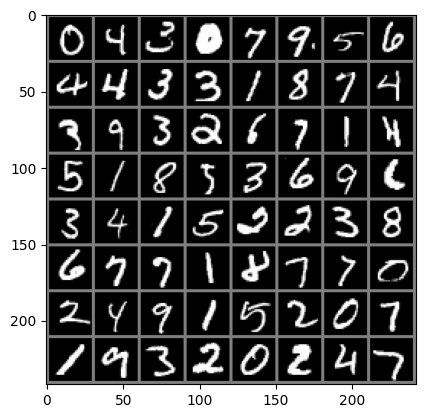

0     4     3     0     7     9     5     6     4     4     3     3     1     8     7     4     3     9     3     2     6     7     1     4     5     1     8     5     3     6     9     6     3     4     1     5     2     2     3     8     6     7     7     1     8     7     7     0     2     4     9     1     5     2     0     7     1     9     3     2     0     2     4     7    


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images,labels = next(dataiter)

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

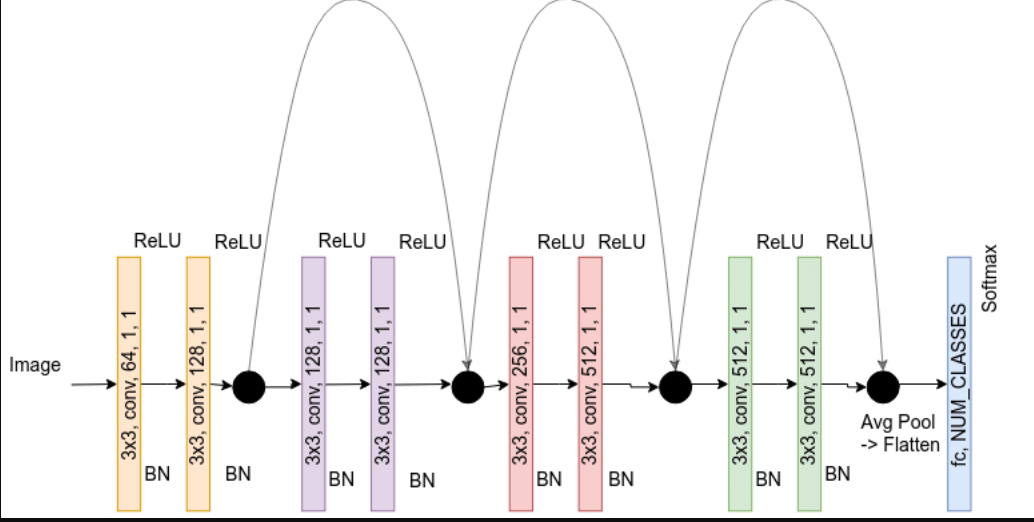

In [ ]:
class Net(nn.Module):
  def __init__(self,in_channels=1,num_classes=10):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=3,stride=1,padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64,128,3,1,1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128,128,3,1,1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128,128,3,1,1)
    self.bn4 = nn.BatchNorm2d(128)
    self.conv5 = nn.Conv2d(128,256,3,1,1)
    self.bn5 = nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(256,512,3,1,1)
    self.bn6 = nn.BatchNorm2d(512)
    self.conv7 = nn.Conv2d(512,512,3,1,1)
    self.bn7 = nn.BatchNorm2d(512)
    self.conv8 = nn.Conv2d(512,512,3,1,1)
    self.bn8 = nn.BatchNorm2d(512)
    self.conv9 = nn.Conv2d(128,512,3,1,1)

    self.pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512,num_classes)

  def forward(self,x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    y = x
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = x + y
    y = x
    x = F.relu(self.bn5(self.conv5(x)))
    x = F.relu(self.bn6(self.conv6(x)))
    x = x + self.conv9(y)
    y = x
    x = F.relu(self.bn7(self.conv7(x)))
    x = F.relu(self.bn8(self.conv8(x)))
    x = x + y

    x = self.pool(x)
    x = torch.flatten(x,1)
    x = F.dropout(x,0.2)
    x = self.fc(x)

    return F.log_softmax(x,dim=1)



In [ ]:
def validator(testloader=None,net=None):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on test images: {100 * correct // total} %')

In [ ]:
def train_model(net=None,trainloader=None,start_epoch=0,end_epoch=10):
  train_losses=[]

  for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times

      running_loss = 0.0
      for data in trainloader:
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
      train_losses.append(running_loss)
      print(f'Epoch: {epoch} Loss: {running_loss}')
      torch.save(
        {'epoch':epoch,
          'model_state_dict': net.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          },
          your_google_drive_path+'checkpoint.pth')

  print('Finished Training')
  plt.plot(range(start_epoch,end_epoch),train_losses)

In [ ]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.01,momentum=0.9)

In [ ]:
start_epoch = 0

checkpoint = torch.load(your_google_drive_path+'checkpoint.pth')
start_epoch = checkpoint['epoch']+1
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

end_epoch = start_epoch + 2

<ipython-input-79-16a433fc1ae5>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(your_google_drive_path+'checkpoint.pth')


Epoch: 10 Loss: 13.478381315231672
Epoch: 11 Loss: 12.910128414943756
Finished Training


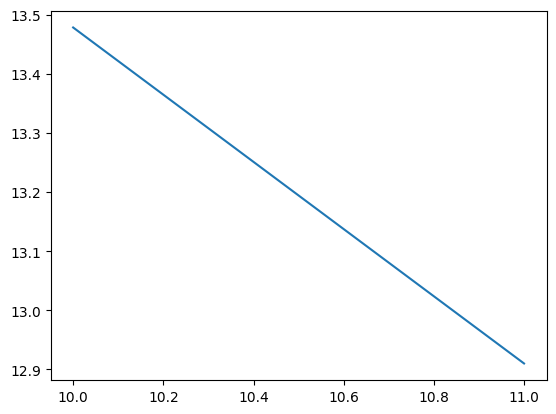

In [ ]:
train_model(net,trainloader,start_epoch,end_epoch)

In [ ]:
current_accuracy = validator(testloader=testloader,net=net)

Accuracy of the network on test images: 99 %


In [ ]:
cmt = torch.zeros((10,10),dtype=torch.int64)

for data in testloader:
    images,labels = data
    images = images.to(device)
    labels = labels.to(device)

    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    for t,p in zip(labels.view(-1),predicted.view(-1)):
      cmt[t.long(),p.long()] += 1

print(cmt)

tensor([[ 973,    0,    2,    0,    0,    0,    3,    0,    2,    0],
        [   0, 1130,    3,    0,    0,    0,    1,    1,    0,    0],
        [   1,    0, 1029,    0,    0,    0,    0,    1,    1,    0],
        [   0,    0,    2, 1004,    0,    2,    0,    0,    2,    0],
        [   0,    0,    0,    0,  980,    0,    0,    0,    0,    2],
        [   1,    0,    1,    4,    0,  884,    1,    1,    0,    0],
        [   2,    2,    1,    0,    3,    1,  948,    0,    1,    0],
        [   0,    4,    8,    2,    4,    0,    0, 1010,    0,    0],
        [   0,    0,    1,    2,    0,    1,    0,    0,  970,    0],
        [   0,    0,    4,    0,   12,    2,    1,    0,    0,  990]])


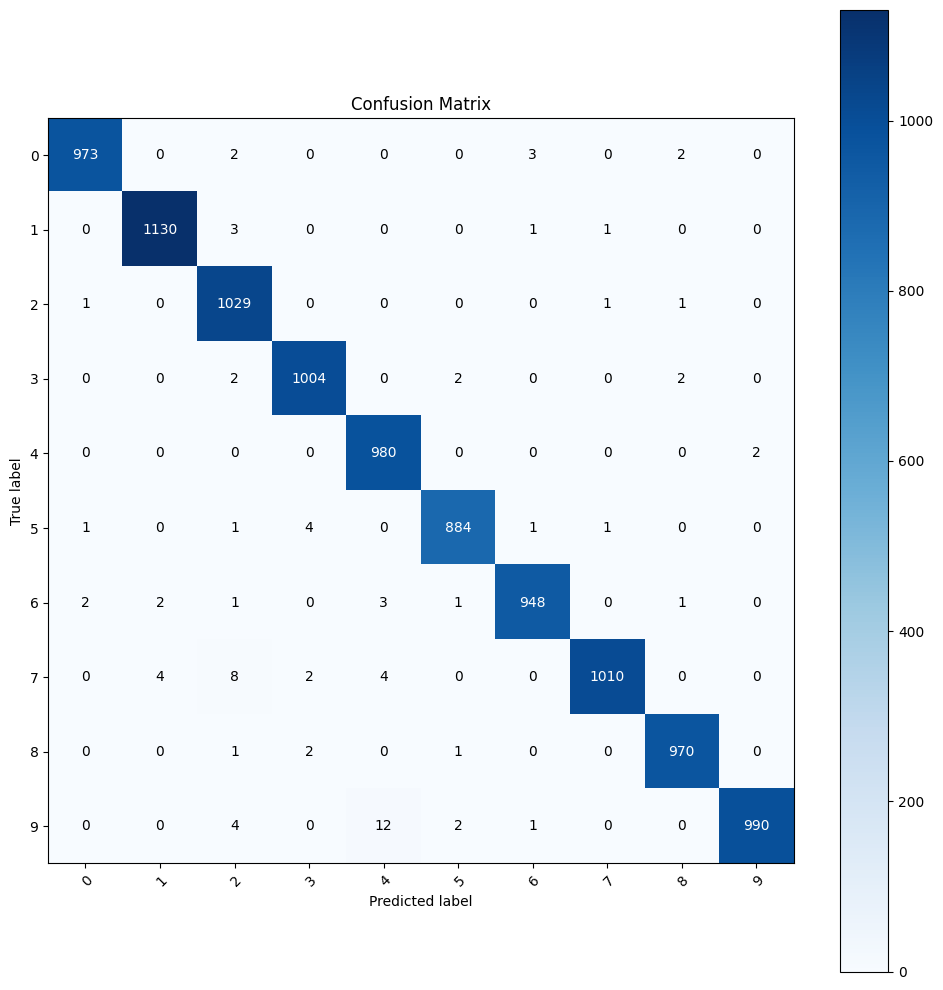

In [ ]:
cm = cmt.cpu().numpy()

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=np.arange(10),
       yticklabels=np.arange(10),
       title='Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

# Telugu Dataset traininig using resnet9

In [ ]:
!mkdir /content/drive/MyDrive/checkpoints2/

mkdir: cannot create directory ‘/content/drive/MyDrive/checkpoints2/’: File exists


In [ ]:
your_google_drive_path = "/content/drive/MyDrive/checkpoints2/"
assert os.path.isdir(your_google_drive_path), f"{your_google_drive_path} is not a valid location"

In [ ]:
import cv2

def extractFiles(op):
  path = "/content/drive/MyDrive/dataset/"
  X = []
  y = []
  folder_path = os.path.join(path,op)
  labels = os.listdir(folder_path)
  for label_folder in labels:
    images = os.listdir(os.path.join(folder_path,label_folder))
    for image in images:
      path = os.path.join(folder_path,label_folder,image)
      img = cv2.imread(path)
      X.append(img)
      y.append(int(label_folder[-1]))
  return np.array(X),np.array(y)

X_train,y_train = extractFiles('train')
X_test,y_test = extractFiles('test')

In [ ]:
X_train = np.transpose(X_train,(0,3,2,1))
X_test = np.transpose(X_test,(0,3,2,1))

train_dataset = list(zip(X_train,y_train))
test_dataset = list(zip(X_test,y_test))

In [ ]:
np.random.shuffle(train_dataset)
np.random.shuffle(test_dataset)

In [ ]:
X_train,y_train = zip(*train_dataset)
X_test,y_test = zip(*test_dataset)

X_train = torch.tensor(np.array(X_train) / 255.0, dtype=torch.float32)
y_train = torch.tensor(np.array(y_train))
X_test = torch.tensor(np.array(X_test) / 255.0, dtype=torch.float32)
y_test = torch.tensor(np.array(y_test))

In [ ]:
def batch_split(X,y,batch_size):

  num_batches = len(X) // batch_size
  batches = [(X[i * batch_size:(i + 1) * batch_size],y[i * batch_size:(i + 1) * batch_size]) for i in range(num_batches)]

  if len(X) % batch_size != 0:
      batches.append((X[num_batches * batch_size:],y[num_batches*batch_size:]))

  return batches

In [ ]:
train_batches = batch_split(X_train,y_train,64)
test_batches = batch_split(X_test,y_test,64)

In [ ]:
model = Net(3,10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
start_epoch = 0

checkpoint = torch.load(your_google_drive_path+'checkpoint.pth',map_location=device)
start_epoch = checkpoint['epoch']+1
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

end_epoch = start_epoch + 10

<ipython-input-93-68c6763e561e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(your_google_drive_path+'checkpoint.pth',map_location=device)


Epoch: 0 Loss: 41.055814027786255
Epoch: 1 Loss: 36.39920675754547
Epoch: 2 Loss: 31.622793436050415
Epoch: 3 Loss: 27.630318999290466
Epoch: 4 Loss: 23.826390385627747
Epoch: 5 Loss: 20.715788960456848
Epoch: 6 Loss: 17.81434792280197
Epoch: 7 Loss: 15.144168436527252
Epoch: 8 Loss: 12.430628895759583
Epoch: 9 Loss: 10.33510172367096
Finished Training


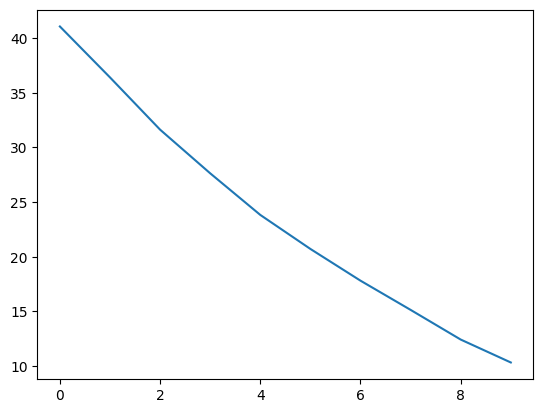

In [ ]:
train_model(model,train_batches,start_epoch,end_epoch)

In [ ]:
validator(test_batches,model)

Accuracy of the network on test images: 94 %


In [ ]:
torch.save(
  {
    'epoch':end_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
    },
    your_google_drive_path+'checkpoint.pth')

# Custom Dataset training (native alphabets)

In [ ]:
from PIL import Image
import os

def extract_images_from_grid(image_path, output_folder, grid_size=(15, 20)):
    # Open the image
    img = Image.open(image_path)

    # Get image width and height
    img_width, img_height = img.size

    # Calculate the width and height of each individual image in the grid
    cell_width = img_width // grid_size[0]
    cell_height = img_height // grid_size[1]

    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through the grid and extract each image
    image_count = 0
    for row in range(grid_size[1]):
        for col in range(grid_size[0]):
            # Define the bounding box for each image
            left = col * cell_width
            upper = row * cell_height
            right = left + cell_width
            lower = upper + cell_height

            # Crop the image
            cropped_img = img.crop((left, upper, right, lower))

            # Save the cropped image
            cropped_img.save(os.path.join(output_folder, f"image_{image_count + 1}.png"))
            image_count += 1

    print(f"Extracted {image_count} images and saved them to {output_folder}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
your_google_drive_path_bengali = '/content/drive/MyDrive/bengali_dataset'
import os
assert os.path.isdir(your_google_drive_path_bengali), f"{your_google_drive_path_bengali} is not a valid location"

In [ ]:
images = os.listdir(your_google_drive_path_bengali + '/All')

for i,image in enumerate(images,0):
  extract_images_from_grid(os.path.join(your_google_drive_path_bengali,'All',image),os.path.join(your_google_drive_path_bengali,str(i)))

Extracted 300 images and saved them to /content/drive/MyDrive/bengali_dataset/0
Extracted 300 images and saved them to /content/drive/MyDrive/bengali_dataset/1
Extracted 300 images and saved them to /content/drive/MyDrive/bengali_dataset/2
Extracted 300 images and saved them to /content/drive/MyDrive/bengali_dataset/3
Extracted 300 images and saved them to /content/drive/MyDrive/bengali_dataset/4
Extracted 300 images and saved them to /content/drive/MyDrive/bengali_dataset/5
Extracted 300 images and saved them to /content/drive/MyDrive/bengali_dataset/6
Extracted 300 images and saved them to /content/drive/MyDrive/bengali_dataset/7
Extracted 300 images and saved them to /content/drive/MyDrive/bengali_dataset/8
Extracted 300 images and saved them to /content/drive/MyDrive/bengali_dataset/9


In [ ]:
from PIL import Image,ImageOps
import os

X = []
y = []

folders = os.listdir(your_google_drive_path_bengali)

for folder in folders:
  if folder == 'All':
    continue
  output_folder = your_google_drive_path_bengali+'/'+folder
  images = os.listdir(output_folder)
  for image in images:
    image_path = output_folder +'/'+image
    img = Image.open(image_path)
    img = img.resize((28,28))
    img = img.convert('L')
    img = ImageOps.invert(img)
    img.save(image_path)
    X.append(img)
    y.append(int(folder))
  print(f"Transformed {len(images)} images and saved them to {output_folder}")

Transformed 300 images and saved them to /content/drive/MyDrive/bengali_dataset/1
Transformed 300 images and saved them to /content/drive/MyDrive/bengali_dataset/2
Transformed 300 images and saved them to /content/drive/MyDrive/bengali_dataset/3
Transformed 300 images and saved them to /content/drive/MyDrive/bengali_dataset/4
Transformed 300 images and saved them to /content/drive/MyDrive/bengali_dataset/5
Transformed 300 images and saved them to /content/drive/MyDrive/bengali_dataset/6
Transformed 300 images and saved them to /content/drive/MyDrive/bengali_dataset/7
Transformed 300 images and saved them to /content/drive/MyDrive/bengali_dataset/8
Transformed 300 images and saved them to /content/drive/MyDrive/bengali_dataset/9
Transformed 300 images and saved them to /content/drive/MyDrive/bengali_dataset/0


In [ ]:
import numpy as np
from torchvision import transforms
import torch

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))]
)

X = np.array([transform(np.array(img)) for img in X])
y = np.array([np.array(label) for label in y])

X = X.reshape((-1,1,28,28))
X = torch.tensor(X)
y = torch.tensor(y)

In [ ]:
from sklearn.model_selection import train_test_split
dataset = list(zip(X,y))
train_set,test_set = train_test_split(dataset,random_state=41,shuffle=True)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 16
trainloader = DataLoader(train_set,batch_size,shuffle=True,num_workers=2)
testloader = DataLoader(test_set,batch_size,shuffle=False,num_workers=2)

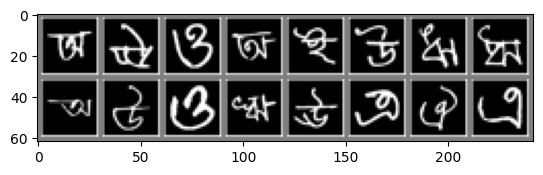

0 5 9 0 2 4 6 6 0 4 9 6 5 7 8 7


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os

classes = ['0','1','2','3','4','5','6','7','8','9']
# print(classes)
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images,labels = next(dataiter)

from torchvision.utils import make_grid
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu')
print(f"We are training on {device} for this experiment")

We are training on cuda:0 for this experiment


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self,in_channels=1,num_classes=10):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=3,stride=1,padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64,128,3,1,1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128,128,3,1,1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128,128,3,1,1)
    self.bn4 = nn.BatchNorm2d(128)
    self.conv5 = nn.Conv2d(128,256,3,1,1)
    self.bn5 = nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(256,512,3,1,1)
    self.bn6 = nn.BatchNorm2d(512)
    self.conv7 = nn.Conv2d(512,512,3,1,1)
    self.bn7 = nn.BatchNorm2d(512)
    self.conv8 = nn.Conv2d(512,512,3,1,1)
    self.bn8 = nn.BatchNorm2d(512)
    self.conv9 = nn.Conv2d(128,512,3,1,1)

    self.pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512,num_classes)

  def forward(self,x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    y = x
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = x + y
    y = x
    x = F.relu(self.bn5(self.conv5(x)))
    x = F.relu(self.bn6(self.conv6(x)))
    x = x + self.conv9(y)
    y = x
    x = F.relu(self.bn7(self.conv7(x)))
    x = F.relu(self.bn8(self.conv8(x)))
    x = x + y

    x = self.pool(x)
    x = torch.flatten(x,1)
    x = F.dropout(x,0.2)
    x = self.fc(x)

    return F.log_softmax(x,dim=1)

In [ ]:
import torch.nn as nn

native_model = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(native_model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
def validator(testloader=None,net=None):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on test images: {100 * correct // total} %')
    return correct/total

In [ ]:
!mkdir /content/drive/MyDrive/checkpoint_bengali

mkdir: cannot create directory ‘/content/drive/MyDrive/checkpoint_bengali’: File exists


In [ ]:
start_epoch=0
end_epoch=10
checkpoint_path = '/content/drive/MyDrive/checkpoint_bengali/'
#If you are resuming your model, Uncomment following lines

# checkpoint = torch.load(checkpoint_path+'checkpoint.pth')
# start_epoch = checkpoint['epoch']+1
# native_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print(inputs.shape)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = native_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 15 == 0:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss}')
        #     running_loss = 0.0
    print(f' Epoch : {epoch} Loss : {running_loss}')
    current_accuracy = validator(testloader=testloader,net=native_model)
    if current_accuracy>best_accuracy:
        best_accuracy = current_accuracy

        torch.save(
            {'epoch':epoch,
             'model_state_dict': native_model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict()
             },

             checkpoint_path+'best_model.pth')

    #Save model as checkpoint
    torch.save(
        {'epoch':epoch,
         'model_state_dict': native_model.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()
         },
         checkpoint_path+'checkpoint.pth')

print('Finished Training')

 Epoch : 0 Loss : 274.2909576892853
Accuracy of the network on test images: 49 %
 Epoch : 1 Loss : 169.2533239722252
Accuracy of the network on test images: 67 %
 Epoch : 2 Loss : 118.67308157682419
Accuracy of the network on test images: 73 %
 Epoch : 3 Loss : 83.55549108982086
Accuracy of the network on test images: 78 %
 Epoch : 4 Loss : 62.833533242344856
Accuracy of the network on test images: 85 %
 Epoch : 5 Loss : 51.8506021425128
Accuracy of the network on test images: 89 %
 Epoch : 6 Loss : 42.57080917060375
Accuracy of the network on test images: 89 %
 Epoch : 7 Loss : 40.11200934648514
Accuracy of the network on test images: 89 %
 Epoch : 8 Loss : 32.06123724207282
Accuracy of the network on test images: 91 %
 Epoch : 9 Loss : 28.49403713643551
Accuracy of the network on test images: 92 %
Finished Training


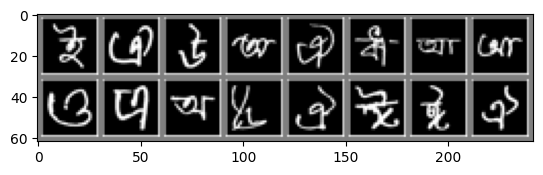

GroundTruth:  2     8     4     0     8     6     1     1     9     7     0     5     8     3     3     8    


In [ ]:
from torchvision.utils import make_grid

dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
net_best = Net().to(device)
checkpoint = torch.load(checkpoint_path+'best_model.pth')
net_best.load_state_dict(checkpoint['model_state_dict'])


images = images.to(device)
labels = labels.to(device)

outputs = net_best(images)

<ipython-input-33-f46e2d740cd2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path+'best_model.pth')


In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(len(predicted))))

Predicted:  2     7     4     0     8     6     1     1     9     7     0     5     8     3     3     8    


In [ ]:
def validator_classwise(testloader=None,net=None, classes=None):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    return #your total accuracy variable

#Test your logic by uncommenting following line
validator_classwise(testloader=testloader,net=net_best, classes=classes)

Accuracy for class: 0     is 95.5 %
Accuracy for class: 1     is 92.9 %
Accuracy for class: 2     is 88.8 %
Accuracy for class: 3     is 97.3 %
Accuracy for class: 4     is 92.3 %
Accuracy for class: 5     is 82.7 %
Accuracy for class: 6     is 100.0 %
Accuracy for class: 7     is 93.7 %
Accuracy for class: 8     is 95.0 %
Accuracy for class: 9     is 95.1 %


# Data Augmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
your_google_drive_path_bengali = '/content/drive/MyDrive/bengali_dataset'
import os
assert os.path.isdir(your_google_drive_path_bengali), f"{your_google_drive_path_bengali} is not a valid location"

In [ ]:
from PIL import Image,ImageOps
import os
from torchvision.transforms import v2
import numpy as np
from torchvision import transforms
import torch

augmented_transforms = v2.Compose([
    v2.RandomResizedCrop(size=(28,28)),
    v2.RandomRotation(45),
])

X = []
y = []

folders = os.listdir(your_google_drive_path_bengali)

for folder in folders:
  if folder == 'All':
    continue
  output_folder = your_google_drive_path_bengali+'/'+folder
  images = os.listdir(output_folder)
  for image in images:
    image_path = output_folder +'/'+image
    img = Image.open(image_path).convert('L')
    img = img.resize((28,28))
    for i in range(10):
      transformed_img = augmented_transforms(img)
      X.append(transformed_img)
      y.append(int(folder))


In [ ]:
import numpy as np
from torchvision import transforms
import torch

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,),(0.5,))]
)

X = np.array([transform(np.array(img)) for img in X])
y = np.array([np.array(label) for label in y])

X = X.reshape((-1,1,28,28))
X = torch.tensor(X)
y = torch.tensor(y)

In [ ]:
from sklearn.model_selection import train_test_split
dataset = list(zip(X,y))
train_set,test_set = train_test_split(dataset,random_state=41,shuffle=True)

from torch.utils.data import DataLoader
batch_size = 32
trainloader = DataLoader(train_set,batch_size,shuffle=True,num_workers=2)
testloader = DataLoader(test_set,batch_size,shuffle=False,num_workers=2)

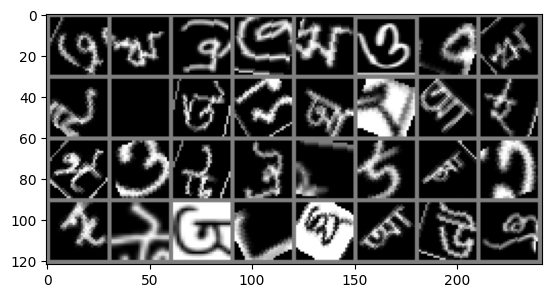

8 6 8 7 6 9 8 6 5 8 5 7 1 0 1 2 3 9 4 8 2 5 1 9 3 4 0 7 0 1 4 7


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import os

classes = ['0','1','2','3','4','5','6','7','8','9']
# print(classes)
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images,labels = next(dataiter)

from torchvision.utils import make_grid
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self,in_channels=1,num_classes=10):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=3,stride=1,padding=1)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64,128,3,1,1)
    self.bn2 = nn.BatchNorm2d(128)
    self.conv3 = nn.Conv2d(128,128,3,1,1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128,128,3,1,1)
    self.bn4 = nn.BatchNorm2d(128)
    self.conv5 = nn.Conv2d(128,256,3,1,1)
    self.bn5 = nn.BatchNorm2d(256)
    self.conv6 = nn.Conv2d(256,512,3,1,1)
    self.bn6 = nn.BatchNorm2d(512)
    self.conv7 = nn.Conv2d(512,512,3,1,1)
    self.bn7 = nn.BatchNorm2d(512)
    self.conv8 = nn.Conv2d(512,512,3,1,1)
    self.bn8 = nn.BatchNorm2d(512)
    self.conv9 = nn.Conv2d(128,512,3,1,1)

    self.pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512,num_classes)

  def forward(self,x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = F.relu(self.bn2(self.conv2(x)))
    y = x
    x = F.relu(self.bn3(self.conv3(x)))
    x = F.relu(self.bn4(self.conv4(x)))
    x = x + y
    y = x
    x = F.relu(self.bn5(self.conv5(x)))
    x = F.relu(self.bn6(self.conv6(x)))
    x = x + self.conv9(y)
    y = x
    x = F.relu(self.bn7(self.conv7(x)))
    x = F.relu(self.bn8(self.conv8(x)))
    x = x + y

    x = self.pool(x)
    x = torch.flatten(x,1)
    x = F.dropout(x,0.2)
    x = self.fc(x)

    return F.log_softmax(x,dim=1)

In [ ]:
import torch.nn as nn

native_model_augmented = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(native_model_augmented.parameters(),lr=0.001,momentum=0.9)

In [ ]:
def validator(testloader=None,net=None):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on test images: {100 * correct // total} %')
    return correct/total

In [ ]:
start_epoch=0
end_epoch=10

# !mkdir '/content/drive/MyDrive/checkpoint_bengali_augmented/'
checkpoint_path = '/content/drive/MyDrive/checkpoint_bengali_augmented/'
#If you are resuming your model, Uncomment following lines

checkpoint = torch.load(checkpoint_path+'checkpoint.pth')
start_epoch = checkpoint['epoch']+1
native_model_augmented.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print(inputs.shape)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = native_model_augmented(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 15 == 0:    # print every 2000 mini-batches
        #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss}')
        #     running_loss = 0.0
    print(f' Epoch : {epoch} Loss : {running_loss}')
    current_accuracy = validator(testloader=testloader,net=native_model_augmented)
    if current_accuracy>best_accuracy:
        best_accuracy = current_accuracy

        torch.save(
            {'epoch':epoch,
             'model_state_dict': native_model_augmented.state_dict(),
             'optimizer_state_dict': optimizer.state_dict()
             },

             checkpoint_path+'best_model.pth')

    #Save model as checkpoint
    torch.save(
        {'epoch':epoch,
         'model_state_dict': native_model_augmented.state_dict(),
         'optimizer_state_dict': optimizer.state_dict()
         },
         checkpoint_path+'checkpoint.pth')

print('Finished Training')

 Epoch : 0 Loss : 1104.166407585144
Accuracy of the network on test images: 51 %
 Epoch : 1 Loss : 805.9863891899586
Accuracy of the network on test images: 62 %
 Epoch : 2 Loss : 653.614433079958
Accuracy of the network on test images: 67 %
 Epoch : 3 Loss : 567.2839150726795
Accuracy of the network on test images: 72 %
 Epoch : 4 Loss : 513.9021092355251
Accuracy of the network on test images: 73 %
 Epoch : 5 Loss : 473.53400379419327
Accuracy of the network on test images: 75 %
 Epoch : 6 Loss : 440.9692180156708
Accuracy of the network on test images: 76 %
 Epoch : 7 Loss : 421.71870398521423
Accuracy of the network on test images: 77 %
 Epoch : 8 Loss : 400.30803190916777
Accuracy of the network on test images: 78 %
 Epoch : 9 Loss : 374.5929486602545
Accuracy of the network on test images: 78 %
Finished Training


<ipython-input-13-6edbe41cf2c8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path+'best_model.pth')


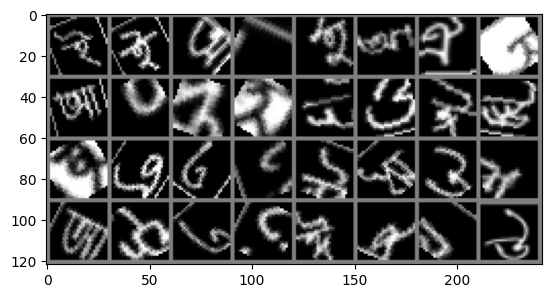

GroundTruth:  2     2     1     5     2     1     8     0     1     5     6     0     5     9     3     5     0     7     7     8     5     6     8     3     1     5     7     9     3     8     8     4    
Predicted:  8     6     8     7     6     9     4     6     5     1     5     7     1     0     1     2     3     9     4     8     3     4     1     9     3     4     0     7     0     1     4     7    


In [ ]:
net_best = Net().to(device)
checkpoint = torch.load(checkpoint_path+'best_model.pth')
net_best.load_state_dict(checkpoint['model_state_dict'])


images = images.to(device)
labels = labels.to(device)

outputs = net_best(images)

from torchvision.utils import make_grid

dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(len(predicted))))

In [ ]:
def validator_classwise(testloader=None,net=None, classes=None):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    return #your total accuracy variable

#Test your logic by uncommenting following line
validator_classwise(testloader=testloader,net=net_best, classes=classes)

Accuracy for class: 0     is 99.6 %
Accuracy for class: 1     is 88.9 %
Accuracy for class: 2     is 63.3 %
Accuracy for class: 3     is 81.0 %
Accuracy for class: 4     is 63.2 %
Accuracy for class: 5     is 66.6 %
Accuracy for class: 6     is 83.8 %
Accuracy for class: 7     is 70.3 %
Accuracy for class: 8     is 80.5 %
Accuracy for class: 9     is 88.7 %


# Transfer Learning with Fine Tuning

In [ ]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else'cpu')
device


device(type='cuda', index=0)

In [ ]:
import torch
checkpoint = torch.load('/content/drive/MyDrive/checkpoints1/checkpoint.pth')
net = Net().to(device)
net.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-60-a139f85e68ce>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/checkpoints1/checkpoint.pth')


<All keys matched successfully>

In [ ]:
for param in net.parameters():#freezing all layers
  param.requires_grad = False

In [ ]:
from torchsummary import summary
summary(net,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3          [-1, 128, 28, 28]          73,856
       BatchNorm2d-4          [-1, 128, 28, 28]             256
            Conv2d-5          [-1, 128, 28, 28]         147,584
       BatchNorm2d-6          [-1, 128, 28, 28]             256
            Conv2d-7          [-1, 128, 28, 28]         147,584
       BatchNorm2d-8          [-1, 128, 28, 28]             256
            Conv2d-9          [-1, 256, 28, 28]         295,168
      BatchNorm2d-10          [-1, 256, 28, 28]             512
           Conv2d-11          [-1, 512, 28, 28]       1,180,160
      BatchNorm2d-12          [-1, 512, 28, 28]           1,024
           Conv2d-13          [-1, 512, 28, 28]         590,336
           Conv2d-14          [-1, 512,

In [ ]:
for param in net.fc.parameters():#unfreezing only the fully connected layer
  param.requires_grad =True

In [ ]:
summary(net,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
       BatchNorm2d-2           [-1, 64, 28, 28]             128
            Conv2d-3          [-1, 128, 28, 28]          73,856
       BatchNorm2d-4          [-1, 128, 28, 28]             256
            Conv2d-5          [-1, 128, 28, 28]         147,584
       BatchNorm2d-6          [-1, 128, 28, 28]             256
            Conv2d-7          [-1, 128, 28, 28]         147,584
       BatchNorm2d-8          [-1, 128, 28, 28]             256
            Conv2d-9          [-1, 256, 28, 28]         295,168
      BatchNorm2d-10          [-1, 256, 28, 28]             512
           Conv2d-11          [-1, 512, 28, 28]       1,180,160
      BatchNorm2d-12          [-1, 512, 28, 28]           1,024
           Conv2d-13          [-1, 512, 28, 28]         590,336
           Conv2d-14          [-1, 512,

In [ ]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [ ]:
start_epoch = 0
end_epoch = 50

In [ ]:
best_accuracy = -1.0
for epoch in range(start_epoch,end_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    current_accuracy = validator(testloader=testloader,net=net)
    print(f'[{epoch + 1}] loss: {running_loss :.3f} accuracy : {current_accuracy : .3f}')

print('Finished Training')

Accuracy of the network on test images: 23 %
[1] loss: 613.749 accuracy :  0.231
Accuracy of the network on test images: 38 %
[2] loss: 349.771 accuracy :  0.389
Accuracy of the network on test images: 49 %
[3] loss: 230.141 accuracy :  0.496
Accuracy of the network on test images: 55 %
[4] loss: 186.866 accuracy :  0.559
Accuracy of the network on test images: 61 %
[5] loss: 163.171 accuracy :  0.611
Accuracy of the network on test images: 63 %
[6] loss: 149.740 accuracy :  0.633
Accuracy of the network on test images: 62 %
[7] loss: 137.440 accuracy :  0.627
Accuracy of the network on test images: 66 %
[8] loss: 128.151 accuracy :  0.668
Accuracy of the network on test images: 68 %
[9] loss: 122.647 accuracy :  0.689
Accuracy of the network on test images: 71 %
[10] loss: 122.170 accuracy :  0.711
Accuracy of the network on test images: 72 %
[11] loss: 115.533 accuracy :  0.725
Accuracy of the network on test images: 73 %
[12] loss: 112.007 accuracy :  0.733
Accuracy of the network o